# Notebook 4: Dimensionality Reduction (PCA)

**Purpose**: Apply PCA/Kernel PCA to reduce features to ≤10 dimensions for QML compatibility.

**Inputs**:
- `feature_engineered_train.csv` from Notebook 3
- `feature_engineered_test.csv` from Notebook 3

**Outputs**:
- `pca_train.csv` → `data/features/`
- `pca_test.csv` → `data/features/`
- `pca_model.pkl` → `models/`

---

In [1]:
# Imports
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
import joblib

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths
BASE_DIR = Path('.').resolve().parent
FEATURES_DIR = BASE_DIR / 'data' / 'features'
MODELS_DIR = BASE_DIR / 'models'
RESULTS_DIR = BASE_DIR / 'results'
FIGURES_DIR = BASE_DIR / 'figures'

# Configuration
TARGET_COLUMN = 'Class'
MAX_COMPONENTS = 10  # Maximum features for QML

print(f"Random Seed: {RANDOM_SEED}")
print(f"Max Components: {MAX_COMPONENTS}")

Random Seed: 42
Max Components: 10


## 1. Load Feature-Engineered Data

In [2]:
# Load data
train_df = pd.read_csv(FEATURES_DIR / 'feature_engineered_train.csv')
test_df = pd.read_csv(FEATURES_DIR / 'feature_engineered_test.csv')

print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

Training set: (1600, 63)
Test set: (400, 63)


In [3]:
# Separate features and target
X_train = train_df.drop(columns=[TARGET_COLUMN])
y_train = train_df[TARGET_COLUMN]

X_test = test_df.drop(columns=[TARGET_COLUMN])
y_test = test_df[TARGET_COLUMN]

print(f"Features before PCA: {X_train.shape[1]}")

Features before PCA: 62


## 2. Variance Analysis (Full PCA)

In [4]:
# Fit full PCA to analyze variance explained
pca_full = PCA(random_state=RANDOM_SEED)
pca_full.fit(X_train)

# Calculate cumulative variance explained
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Total components: {len(explained_variance)}")
print(f"\nVariance explained by first {MAX_COMPONENTS} components: {cumulative_variance[MAX_COMPONENTS-1]*100:.2f}%")

Total components: 62

Variance explained by first 10 components: 98.42%


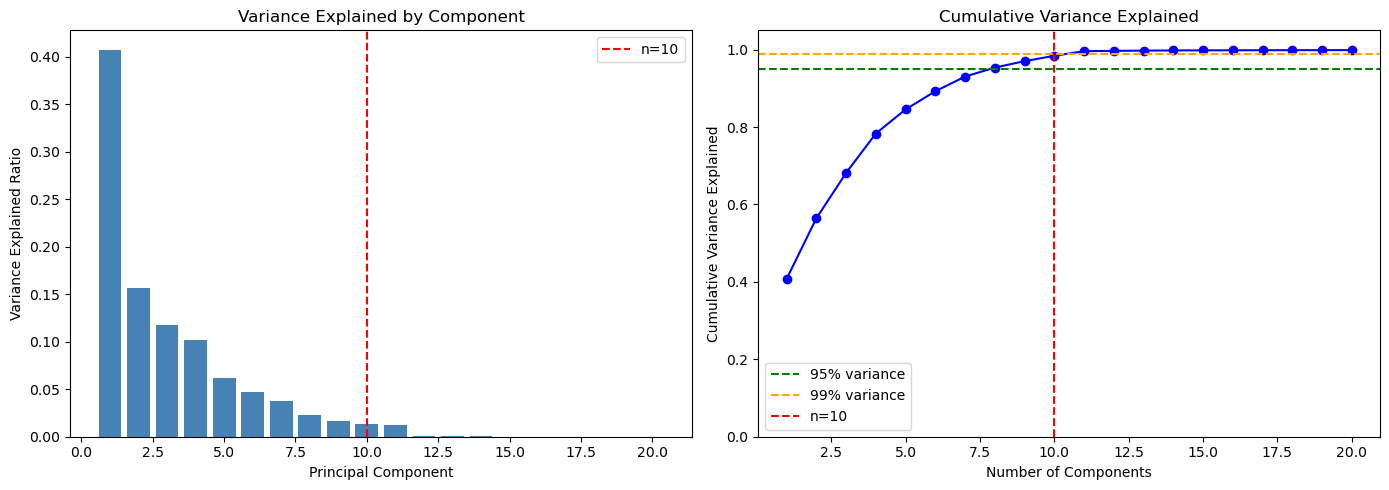

In [5]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual variance
n_show = min(20, len(explained_variance))
axes[0].bar(range(1, n_show+1), explained_variance[:n_show], color='steelblue')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained Ratio')
axes[0].set_title('Variance Explained by Component')
axes[0].axvline(x=MAX_COMPONENTS, color='red', linestyle='--', label=f'n={MAX_COMPONENTS}')
axes[0].legend()

# Cumulative variance
axes[1].plot(range(1, n_show+1), cumulative_variance[:n_show], 'bo-')
axes[1].axhline(y=0.95, color='green', linestyle='--', label='95% variance')
axes[1].axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
axes[1].axvline(x=MAX_COMPONENTS, color='red', linestyle='--', label=f'n={MAX_COMPONENTS}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_variance_explained.png', dpi=150)
plt.show()

## 3. Optimal Component Selection

In [6]:
# Find minimum components for different variance thresholds
thresholds = [0.90, 0.95, 0.99]

print("Components needed for variance thresholds:")
for thresh in thresholds:
    n_components = np.argmax(cumulative_variance >= thresh) + 1
    print(f"  {thresh*100:.0f}% variance: {n_components} components")

# We'll use MAX_COMPONENTS as our target
n_components = MAX_COMPONENTS
print(f"\n✅ Using {n_components} components (captures {cumulative_variance[n_components-1]*100:.2f}% variance)")

Components needed for variance thresholds:
  90% variance: 7 components
  95% variance: 8 components
  99% variance: 11 components

✅ Using 10 components (captures 98.42% variance)


## 4. Apply PCA

In [7]:
# Fit PCA with selected number of components
pca = PCA(n_components=n_components, random_state=RANDOM_SEED)

# Fit on training data, transform both
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Create column names
pca_columns = [f'PC{i+1}' for i in range(n_components)]

# Convert to DataFrame
X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns, index=X_train.index)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns, index=X_test.index)

print(f"Training PCA shape: {X_train_pca_df.shape}")
print(f"Test PCA shape: {X_test_pca_df.shape}")

Training PCA shape: (1600, 10)
Test PCA shape: (400, 10)


In [8]:
# Display component statistics
print("PCA Component Statistics (Training):")
print(X_train_pca_df.describe())

PCA Component Statistics (Training):
                PC1           PC2           PC3           PC4           PC5  \
count  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03   
mean   2.486900e-16 -2.842171e-16  3.552714e-17 -1.421085e-16 -1.776357e-16   
std    8.100832e+01  5.021584e+01  4.344912e+01  4.047030e+01  3.167818e+01   
min   -1.319167e+03 -7.892718e+02 -7.008934e+02 -1.436570e+03 -7.917873e+02   
25%   -1.464552e+00 -2.375643e+00 -1.946413e+00  1.920702e-01 -5.747007e-01   
50%   -5.334161e-01 -1.475116e+00 -9.715629e-01  1.289576e+00  2.072687e-01   
75%    5.646438e-01 -7.809505e-01  5.034818e-01  2.648338e+00  9.854600e-01   
max    2.643752e+03  1.551132e+03  1.099018e+03  2.538560e+02  4.561534e+02   

               PC6           PC7           PC8           PC9          PC10  
count  1600.000000  1.600000e+03  1.600000e+03  1.600000e+03  1.600000e+03  
mean      0.000000  7.815970e-16  7.105427e-17 -2.309264e-16  1.421085e-16  
std      27.488606  

## 5. Visualize Principal Components

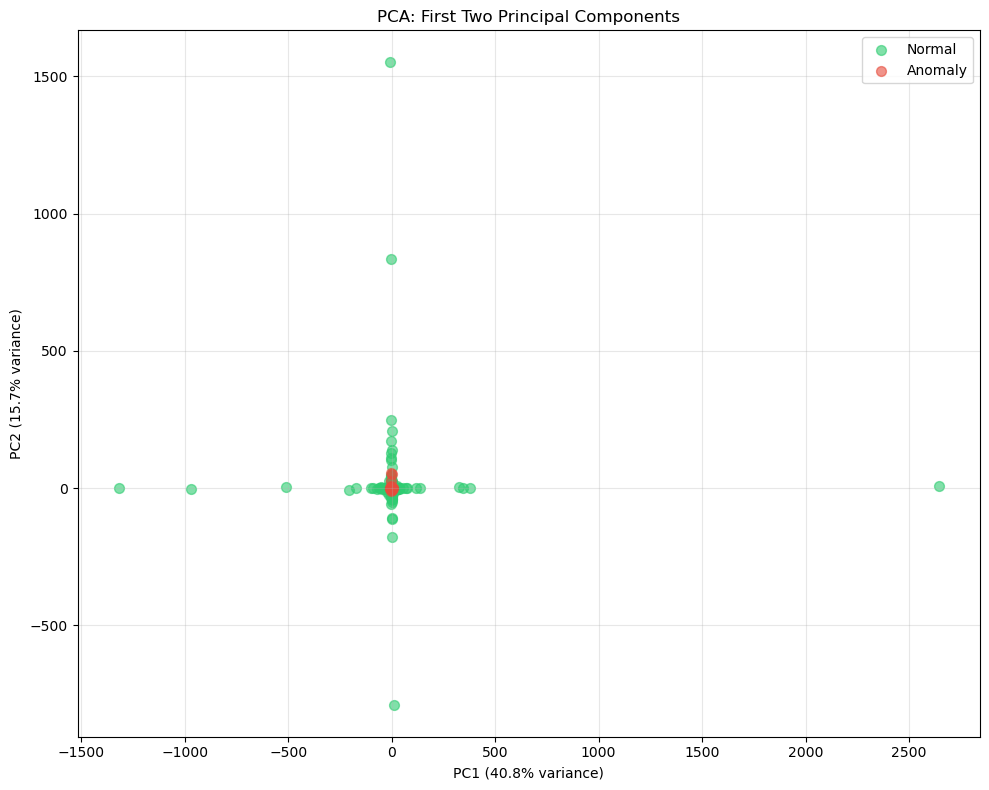

In [9]:
# 2D scatter plot of first two components
plt.figure(figsize=(10, 8))

colors = ['#2ecc71', '#e74c3c']
labels = ['Normal', 'Anomaly']

for i, label in enumerate([0, 1]):
    mask = y_train == label
    plt.scatter(
        X_train_pca_df.loc[mask, 'PC1'],
        X_train_pca_df.loc[mask, 'PC2'],
        c=colors[i],
        label=labels[i],
        alpha=0.6,
        s=50
    )

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title('PCA: First Two Principal Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_2d_scatter.png', dpi=150)
plt.show()

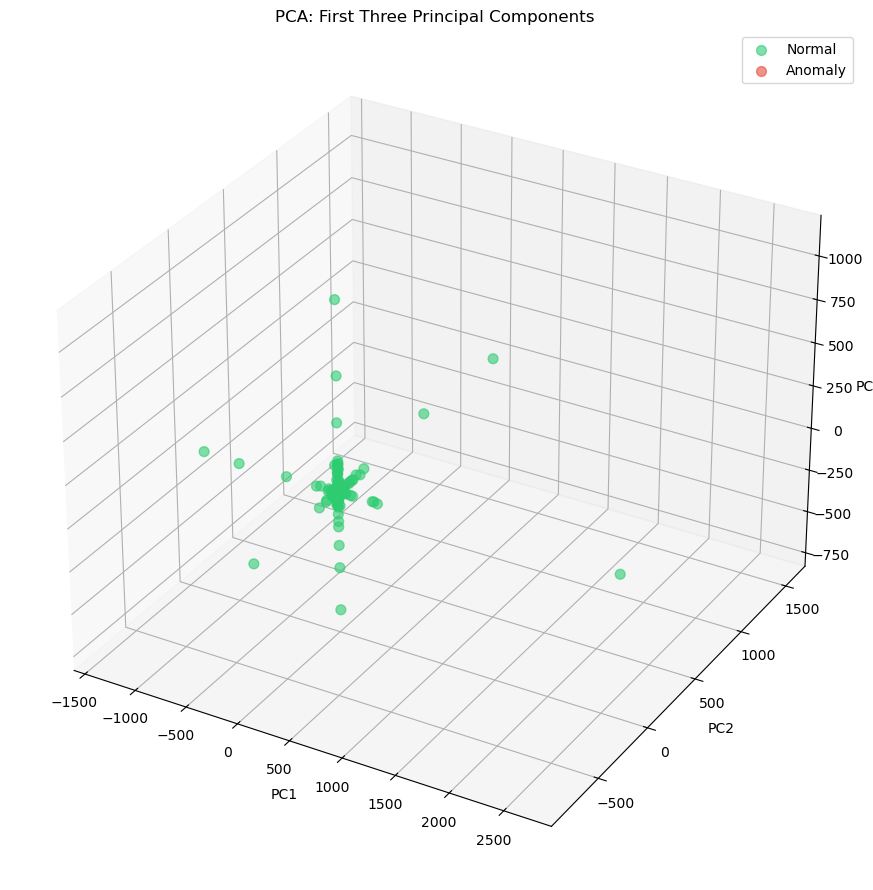

In [10]:
# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate([0, 1]):
    mask = y_train == label
    ax.scatter(
        X_train_pca_df.loc[mask, 'PC1'],
        X_train_pca_df.loc[mask, 'PC2'],
        X_train_pca_df.loc[mask, 'PC3'],
        c=colors[i],
        label=labels[i],
        alpha=0.6,
        s=50
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA: First Three Principal Components')
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_3d_scatter.png', dpi=150)
plt.show()

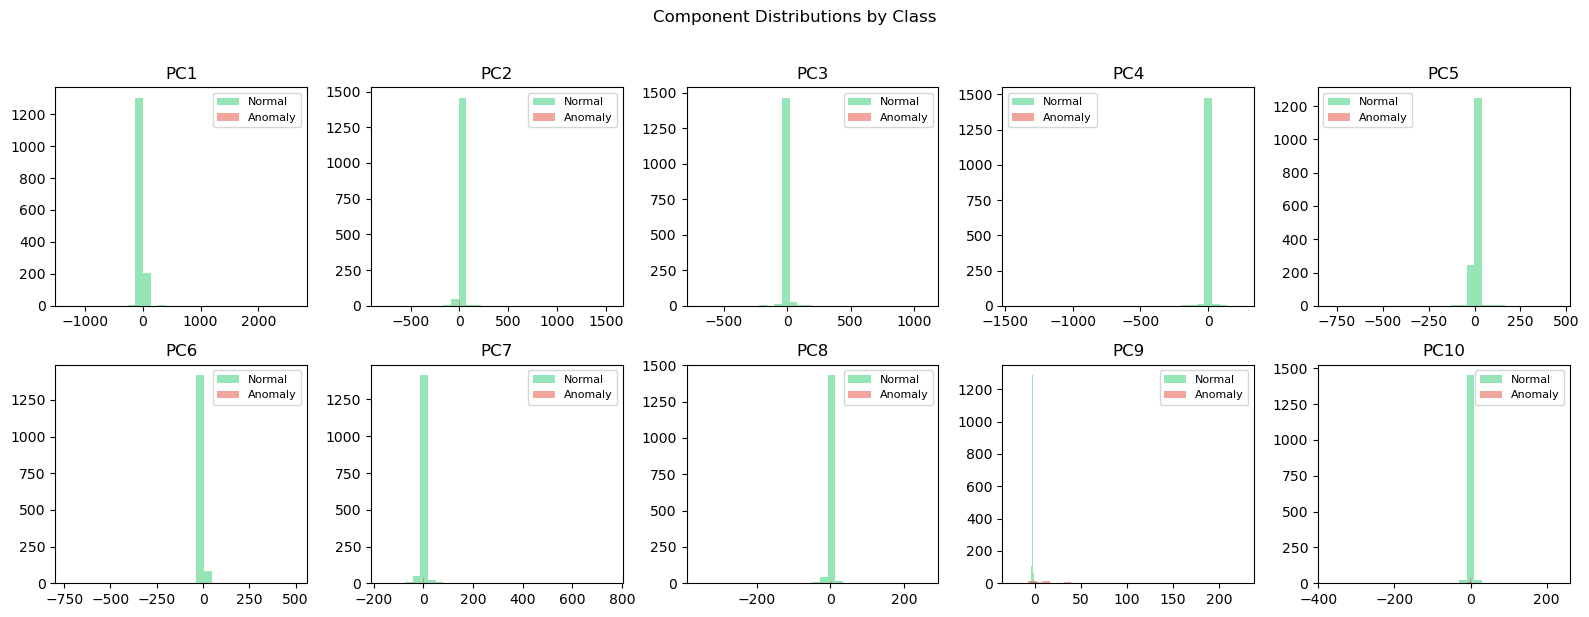

In [11]:
# Component distributions by class
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()

for i, col in enumerate(pca_columns):
    ax = axes[i]
    for j, label in enumerate([0, 1]):
        mask = y_train == label
        ax.hist(
            X_train_pca_df.loc[mask, col],
            bins=30,
            alpha=0.5,
            color=colors[j],
            label=labels[j]
        )
    ax.set_title(col)
    ax.legend(fontsize=8)

plt.suptitle('Component Distributions by Class', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_component_distributions.png', dpi=150)
plt.show()

## 6. Save Outputs

In [12]:
# Combine with target
train_pca_final = X_train_pca_df.copy()
train_pca_final[TARGET_COLUMN] = y_train.values

test_pca_final = X_test_pca_df.copy()
test_pca_final[TARGET_COLUMN] = y_test.values

print(f"Final training shape: {train_pca_final.shape}")
print(f"Final test shape: {test_pca_final.shape}")

Final training shape: (1600, 11)
Final test shape: (400, 11)


In [13]:
# Save PCA data
train_path = FEATURES_DIR / 'pca_train.csv'
test_path = FEATURES_DIR / 'pca_test.csv'

train_pca_final.to_csv(train_path, index=False)
test_pca_final.to_csv(test_path, index=False)

print(f"✅ Saved PCA training data to: {train_path}")
print(f"✅ Saved PCA test data to: {test_path}")

✅ Saved PCA training data to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\features\pca_train.csv
✅ Saved PCA test data to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\data\features\pca_test.csv


In [14]:
# Save PCA model
pca_path = MODELS_DIR / 'pca_model.pkl'
joblib.dump(pca, pca_path)
print(f"✅ Saved PCA model to: {pca_path}")

✅ Saved PCA model to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\models\pca_model.pkl


In [15]:
# Save PCA metadata
pca_metadata = {
    "random_seed": RANDOM_SEED,
    "n_components": n_components,
    "original_features": X_train.shape[1],
    "variance_explained": {
        "per_component": [round(v, 4) for v in pca.explained_variance_ratio_],
        "cumulative": round(sum(pca.explained_variance_ratio_), 4)
    },
    "component_names": pca_columns
}

with open(RESULTS_DIR / 'pca_metadata.json', 'w') as f:
    json.dump(pca_metadata, f, indent=2)

print(f"✅ Saved PCA metadata")

✅ Saved PCA metadata


## 7. Verification

In [16]:
# Verify saved files
train_verify = pd.read_csv(FEATURES_DIR / 'pca_train.csv')
test_verify = pd.read_csv(FEATURES_DIR / 'pca_test.csv')
pca_verify = joblib.load(MODELS_DIR / 'pca_model.pkl')

print("Verification:")
print(f"  Training shape: {train_verify.shape}")
print(f"  Test shape: {test_verify.shape}")
print(f"  PCA components: {pca_verify.n_components_}")
print(f"  Features (excl. target): {len(train_verify.columns) - 1}")
print(f"\n✅ Notebook 4 Complete!")

Verification:
  Training shape: (1600, 11)
  Test shape: (400, 11)
  PCA components: 10
  Features (excl. target): 10

✅ Notebook 4 Complete!


In [17]:
# Summary
print("\n" + "="*50)
print("PCA SUMMARY")
print("="*50)
print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {n_components}")
print(f"Variance retained: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"Dimensionality reduction: {(1 - n_components/X_train.shape[1])*100:.1f}%")


PCA SUMMARY
Original features: 62
Reduced features: 10
Variance retained: 98.42%
Dimensionality reduction: 83.9%
